In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hshma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
# Import Dataset
family_df = pd.read_csv('./Stored_Dataframes/family_df_with_topics.csv')
topic_family_df = family_df[['clean_text']]
topic_family_df.head()

,clean_text
0,They think my sister has Corona 👀
1,It’s a sad day 😔 my mom was suppose to see her...
2,Did I really just hear my mom say “You got coc...
3,@_abigailelainee @Bubba_Dade We already had th...
4,How would you like to #quarantine here at our ...


In [5]:
# Convert to list
data = topic_family_df.clean_text.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[:2])

['They think my sister has Corona 👀',
 'It’s a sad day 😔 my mom was suppose to see her mom after not seeing her for '
 '20 years tomorrow but with this corona virus shit they closed the frontera '
 'and won’t be able to see her 😓💔 they were so excited to see each other it '
 'break my heart for them both!']


In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['they', 'think', 'my', 'sister', 'has', 'corona']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['they', 'think', 'my', 'sister', 'has', 'corona']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# nlp = en_core_web_sm.load(disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[!] Skipping model package dependencies and setting `--no-deps`. You don't seem
to have the spaCy package itself installed (maybe because you've built from
source?), so installing the model dependencies would cause spaCy to be
downloaded, which probably isn't what you want. If the model package has other
dependencies, you'll have to install them manually.
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[['think'], ['sad', 'mom', 'suppose', 'see', 'mom', 'see', 'year', 'tomorrow', 'corona', 'virus', 'shit', 'close', 'frontera', 'able', 'see', 'excited', 'break', 'heart']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:3])

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(4, 1), (8, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]]


In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"time" + 0.025*"week" + 0.025*"see" + 0.020*"take" + 0.017*"come" + '
  '0.017*"thing" + 0.017*"test" + 0.015*"want" + 0.015*"back" + 0.015*"life"'),
 (1,
  '0.036*"moment" + 0.014*"quarantine" + 0.009*"health" + 0.008*"show" + '
  '0.007*"world" + 0.007*"birthday" + 0.007*"face" + 0.006*"plan" + '
  '0.006*"issue" + 0.006*"change"'),
 (2,
  '0.064*"covid" + 0.024*"mom" + 0.023*"get" + 0.019*"go" + 0.015*"pandemic" + '
  '0.013*"year" + 0.012*"amp" + 0.012*"die" + 0.010*"mother" + 0.010*"say"')]


In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.574604643657898

Coherence Score:  0.25504652499537284


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\hshma\anaconda3\envs\D3M\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.354867 -0.060149       1        1  62.501899
0      0.235840 -0.244013       2        1  24.222010
1      0.119027  0.304162       3        1  13.276091, topic_info=          Term          Freq         Total Category  logprob  loglift
140      covid  32438.000000  32438.000000  Default  30.0000  30.0000
74        time   5848.000000   5848.000000  Default  29.0000  29.0000
128     moment   3912.000000   3912.000000  Default  28.0000  28.0000
225       week   4952.000000   4952.000000  Default  27.0000  27.0000
10         see   4912.000000   4912.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
1647      word    486.561982    487.404796   Topic3  -5.4008   2.0175
129      ready    465.994556    466.824731   Topic3  -5.4440   2.0174
915   struggle    457.441589    458.259206   Topic3  -5.4626   2.0174
371      small    415.382522    416.149228   Topic3  -5.5590   2.0174
1909     music    441.256057    442.073510   Topic3  -5.4986   2.0174

[124 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
308       3  0.997800  amazing
41        1  0.999939      amp
205       2  0.999893     back
206       2  0.999255      bad
24        3  0.997392       be
...     ...       ...      ...
1647      3  0.999169     word
110       1  0.999811     work
337       3  0.999395    world
36        1  0.999855    would
15        1  0.999913     year

[97 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print("done num_topics={}".format(num_topics))

    return model_list, coherence_values

In [16]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

done num_topics=2
done num_topics=3
done num_topics=4
done num_topics=5
done num_topics=6
done num_topics=7
done num_topics=8
done num_topics=9


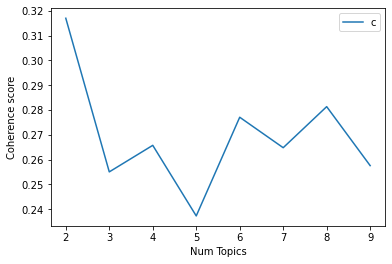

In [21]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.317
Num Topics = 3  has Coherence Value of 0.255
Num Topics = 4  has Coherence Value of 0.2657
Num Topics = 5  has Coherence Value of 0.2373
Num Topics = 6  has Coherence Value of 0.2771
Num Topics = 7  has Coherence Value of 0.2648
Num Topics = 8  has Coherence Value of 0.2813
Num Topics = 9  has Coherence Value of 0.2576


In [24]:
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.052*"covid" + 0.019*"mom" + 0.019*"get" + 0.016*"go" + 0.010*"year" + '
  '0.010*"time" + 0.009*"die" + 0.009*"take" + 0.008*"mother" + 0.008*"say"'),
 (1,
  '0.040*"pandemic" + 0.020*"moment" + 0.016*"help" + 0.012*"kid" + '
  '0.009*"new" + 0.008*"child" + 0.008*"amp" + 0.008*"school" + 0.006*"job" + '
  '0.005*"state"')]


In [43]:
# optimal_model[corpus][0]
print(optimal_model[corpus][3])
# print(optimal_model[corpus][4])
# print(sorted(optimal_model[corpus][3], key=lambda x: (x[1]), reverse=True))
tst=optimal_model[corpus][3][0]
print(sorted(tst, key=lambda x: (x[1]), reverse=True))

([(0, 0.8580689), (1, 0.14193107)], [(4, [0]), (23, [0]), (24, [0]), (25, [0])], [(4, [(0, 0.99988383)]), (23, [(0, 0.9996254)]), (24, [(0, 0.9995811)]), (25, [(0, 0.9972767)])])
[(0, 0.8580689), (1, 0.14193107)]


In [44]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = row[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.8010,"covid, mom, get, go, year, time, die, take, mo...",They think my sister has Corona 👀
1,1,0.0,0.9350,"covid, mom, get, go, year, time, die, take, mo...",It’s a sad day 😔 my mom was suppose to see her...
2,2,0.0,0.8284,"covid, mom, get, go, year, time, die, take, mo...",Did I really just hear my mom say “You got coc...
3,3,0.0,0.8581,"covid, mom, get, go, year, time, die, take, mo...",@_abigailelainee @Bubba_Dade We already had th...
4,4,0.0,0.6324,"covid, mom, get, go, year, time, die, take, mo...",How would you like to #quarantine here at our ...
5,5,0.0,0.7558,"covid, mom, get, go, year, time, die, take, mo...",This corona virus killing all the hoes shuga d...
6,6,0.0,0.6893,"covid, mom, get, go, year, time, die, take, mo...",.@RandPaul i thought your father said Corona V...
7,7,0.0,0.8432,"covid, mom, get, go, year, time, die, take, mo...",@____akua Look like Corona Grandpa 👴
8,8,0.0,0.8430,"covid, mom, get, go, year, time, die, take, mo...",@OwnerOfABoner_ @WubsNet @Bellacats1953 @MomKi...
9,9,0.0,0.8687,"covid, mom, get, go, year, time, die, take, mo...",So my mom just told me they aren’t testing any...


In [45]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9562,"covid, mom, get, go, year, time, die, take, mo...",Little did I know a year ago today would be th...
1,1.0,0.7898,"pandemic, moment, help, kid, new, child, amp, ...",@shaygribbs13 wrote this great article about s...


In [47]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",61972.0,0.9582
1.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",2705.0,0.0418
2.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",NaN,NaN
3.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",NaN,NaN
4.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",NaN,NaN
...,...,...,...,...
64672.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",NaN,NaN
64673.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",NaN,NaN
64674.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",NaN,NaN
64675.0,0.0,"covid, mom, get, go, year, time, die, take, mo...",NaN,NaN
